## Préparation des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = "drive/MyDrive/CNN_classification"
path_images = "drive/MyDrive/CNN_classification/Images"
path_images_tmp = "drive/MyDrive/CNN_classification/images_tmp"

Mounted at /content/drive


In [ ]:
# !pip install split-folders

In [ ]:
# Import des librairies nécessaires

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from glob import glob 
import tarfile
import regex as re
import scipy.io
from scipy.io import loadmat
from bs4 import BeautifulSoup
from collections import Counter
import pickle
import os
import gc
import random
# import splitfolders
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model

In [ ]:
SIZE_2D = (299, 299)
SIZE_3D = (299, 299, 3)
BATCH_SIZE = 32

In [ ]:
def show_values_on_bars(axs, h_v="h", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def get_race_from_path(path):
    tmp =  os.path.dirname(path).rsplit("/", 1)[-1]
    return re.sub("n[0-9]+-", "", tmp).upper()

get_race_from_dir = lambda x: re.sub("n[0-9]+-", "", x).upper()

# Afin d'essayer de comprendre pourquoi l'algorithme s'est trompé

def check_plot(paths, race_true, race_pred):
  df_tmp = pd.DataFrame()

  df_tmp["path"] = paths
  df_tmp["race"] = df_tmp.path.map(get_race_from_path)

  path_a = random.choice(df_tmp[df_tmp.race == race_true].path.tolist())
  path_b = random.choice(df_tmp[df_tmp.race == race_pred].path.tolist())

  fig = plt.figure(figsize = (12, 12))

  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(load_img(path_a))
  ax1.grid(False)

  ax2 = fig.add_subplot(2,2,2)
  ax2.imshow(load_img(path_b))
  ax2.grid(False)

  return 

In [ ]:
images = glob("{}/*/*.jpg".format(path_images))
print("Nombre d'images : {}".format(len(images)))

Nombre d'images : 20580


Race du chien : BLENHEIM_SPANIEL




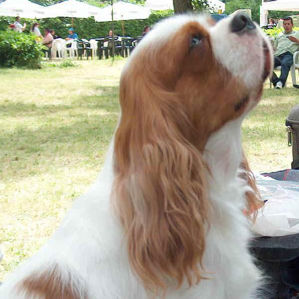

In [ ]:
img = random.choice(images)

print("Race du chien : {}\n\n".format(get_race_from_path(img)))

display(load_img(img).resize(SIZE_2D))

In [ ]:
# splitfolders.ratio(path_images, output="{}/Images_split".format(root), seed=1337, ratio=(.8, .2))

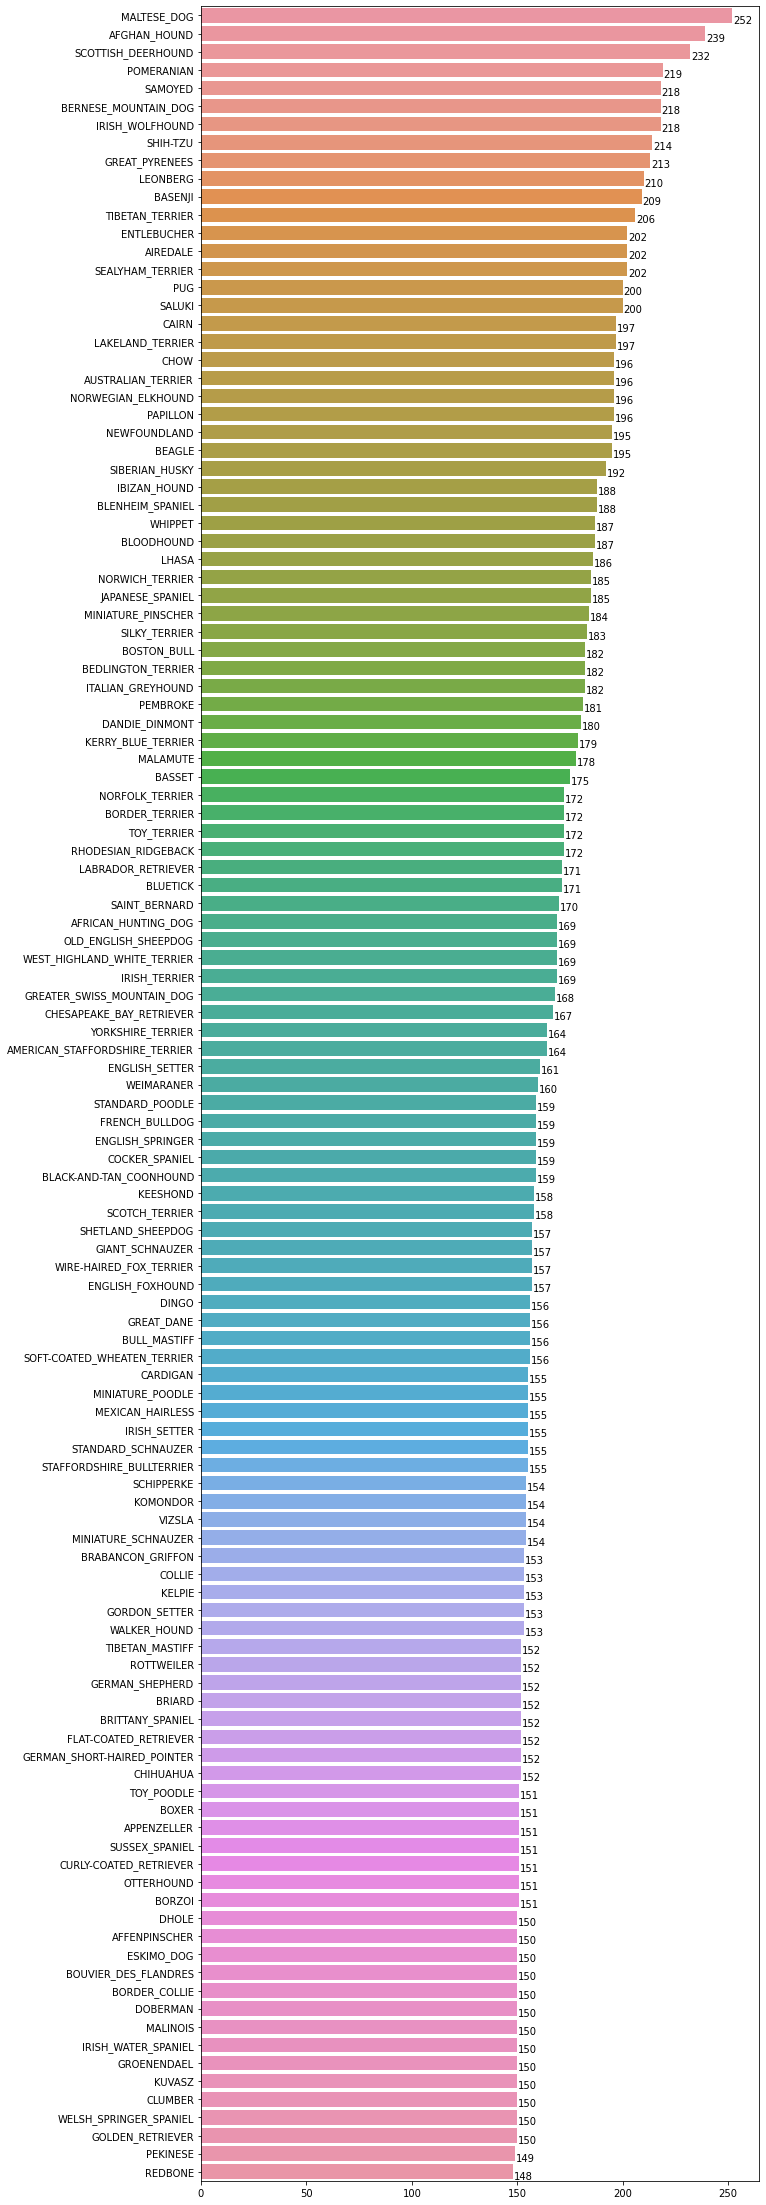

In [ ]:
classes = []
nb_images = []

for img_dirs in os.listdir("{}/Images".format(root)):

  classes.append(get_race_from_dir(img_dirs))
  nom_dir = "{}/Images/{}".format(root, img_dirs)
  nb_images.append(len(os.listdir(nom_dir)))

tuples = list(zip(classes, nb_images))
tuples = list(sorted(tuples, key = lambda x: x[1], reverse = True))

tuples = list(zip(classes, nb_images))
tuples = list(sorted(tuples, key = lambda x: x[1], reverse = True))

plt.figure(figsize = (10, 40))
ax = sns.barplot(y = list(list(zip(*tuples))[0]), x = list(list(zip(*tuples))[1]))
show_values_on_bars(ax, h_v="h", space=0.4)
plt.savefig('{}/repartition_fichiers.png'.format(root))
plt.show()

In [ ]:
train_dataset_full = tf.keras.utils.image_dataset_from_directory (
            "{}/Images_split/train".format(root),
            image_size = SIZE_2D,
            batch_size=BATCH_SIZE)

val_dataset_full = tf.keras.utils.image_dataset_from_directory(
            '{}/Images_split/val'.format(root),
            image_size = SIZE_2D,
            batch_size=BATCH_SIZE,
            shuffle = False)

n_races_full = len(train_dataset_full.class_names)

Found 16418 files belonging to 120 classes.
Found 4162 files belonging to 120 classes.


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory (
            "{}/images_tmp_split/train".format(root),
            image_size = SIZE_2D,
            batch_size=BATCH_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
            '{}/images_tmp_split/val'.format(root),
            image_size = SIZE_2D,
            batch_size=BATCH_SIZE,
            shuffle = False)

n_races = len(train_dataset.class_names)

Found 1531 files belonging to 10 classes.
Found 388 files belonging to 10 classes.


In [ ]:
# https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [ ]:
y_true = []
i = 0

for i, classe in enumerate(train_dataset_full.class_names): 
  n_tmp = len(os.listdir('{}/Images_split/val/{}'.format(root, classe)))
  y_true = np.concatenate((y_true, np.full(n_tmp, i)))

From scratch

In [ ]:
# on teste dans un premier temps un modèle assez simple
inputs = keras.Input(shape=SIZE_3D)
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(n_races, activation="softmax")(x)

model_from_scratch = keras.Model(inputs=inputs, outputs=outputs)

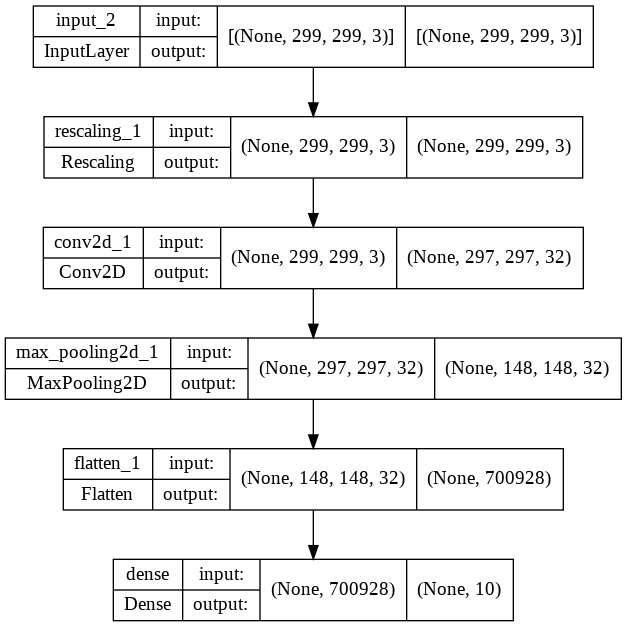

In [ ]:
tf.keras.utils.plot_model(model_from_scratch, show_shapes=True, to_file = '{}/model_FS_basic.png'.format(root))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


48/48 [==============================] - 250s 4s/step - loss: 29.9785 - accuracy: 0.1202 - val_loss: 2.3820 - val_accuracy: 0.1675
Epoch 2/20
48/48 [==============================] - 6s 115ms/step - loss: 1.9382 - accuracy: 0.3638 - val_loss: 2.3472 - val_accuracy: 0.2010
Epoch 3/20
48/48 [==============================] - 6s 113ms/step - loss: 1.0008 - accuracy: 0.7433 - val_loss: 2.3510 - val_accuracy: 0.2526
Epoch 4/20
48/48 [==============================] - 6s 113ms/step - loss: 0.3333 - accuracy: 0.9412 - val_loss: 2.7697 - val_accuracy: 0.2577
Epoch 5/20
48/48 [==============================] - 6s 114ms/step - loss: 0.1202 - accuracy: 0.9869 - val_loss: 2.9329 - val_accuracy: 0.2474
Epoch 6/20
48/48 [==============================] - 6s 114ms/step - loss: 0.0572 - accuracy: 0.9961 - val_loss: 3.3156 - val_accuracy: 0.2655
Epoch 7/20
48/48 [==============================] - 6s 114ms/step - loss: 0.0442 - accuracy: 0.9974 - val_loss: 2.9789 - val_accuracy: 0.2732
Epoch 8/20
48/48 

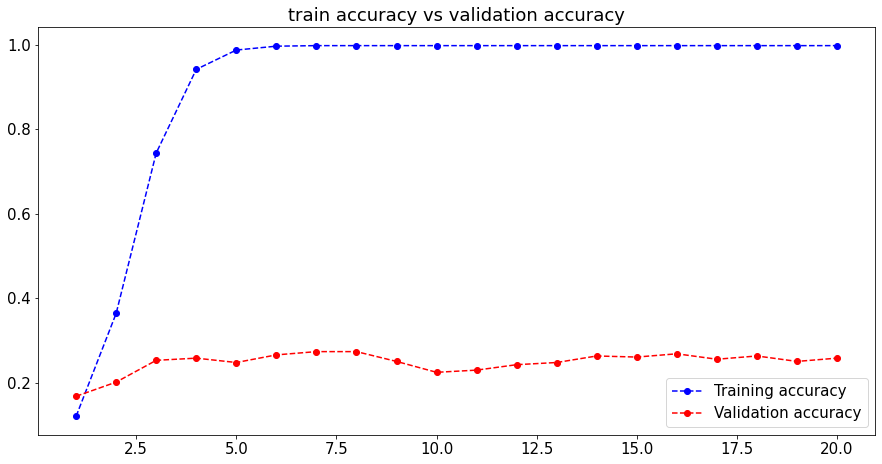

<Figure size 432x288 with 0 Axes>

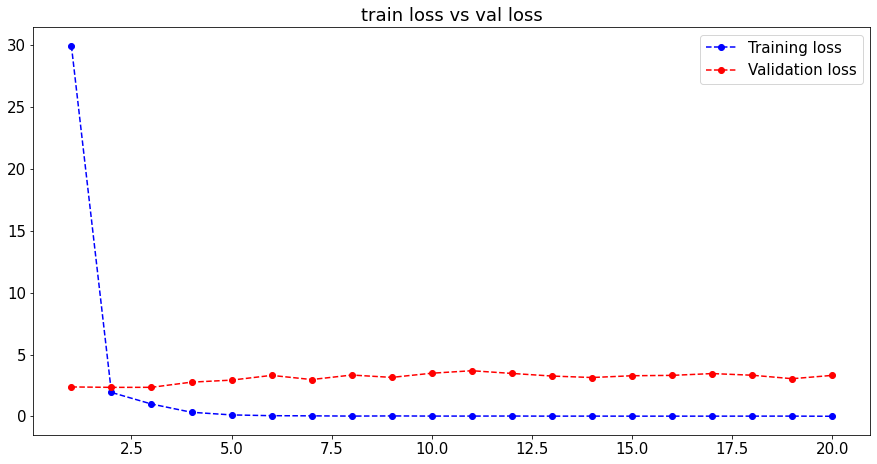

In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.001)

model_from_scratch.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer,
metrics=["accuracy"])

history = model_from_scratch.fit_generator(
    train_dataset,
    epochs=20,
    validation_data=val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


48/48 [==============================] - 7s 117ms/step - loss: 2.5165 - accuracy: 0.1528 - val_loss: 2.2627 - val_accuracy: 0.1649
Epoch 2/20
48/48 [==============================] - 6s 116ms/step - loss: 2.1681 - accuracy: 0.2234 - val_loss: 2.1013 - val_accuracy: 0.2191
Epoch 3/20
48/48 [==============================] - 6s 115ms/step - loss: 2.0341 - accuracy: 0.2613 - val_loss: 2.1426 - val_accuracy: 0.1933
Epoch 4/20
48/48 [==============================] - 6s 116ms/step - loss: 1.9628 - accuracy: 0.3109 - val_loss: 2.1108 - val_accuracy: 0.2474
Epoch 5/20
48/48 [==============================] - 6s 115ms/step - loss: 1.9074 - accuracy: 0.3364 - val_loss: 2.0994 - val_accuracy: 0.2577
Epoch 6/20
48/48 [==============================] - 6s 114ms/step - loss: 1.8630 - accuracy: 0.3508 - val_loss: 2.0759 - val_accuracy: 0.2655
Epoch 7/20
48/48 [==============================] - 6s 115ms/step - loss: 1.8391 - accuracy: 0.3697 - val_loss: 2.0838 - val_accuracy: 0.2912
Epoch 8/20
48/48 

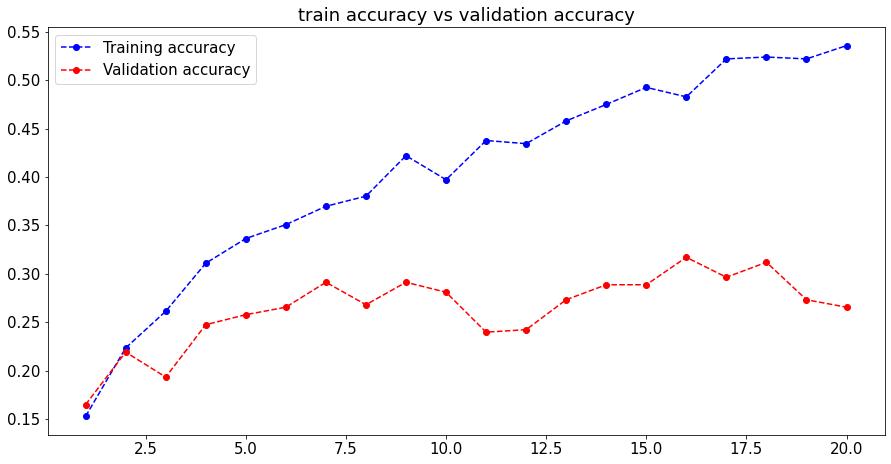

<Figure size 432x288 with 0 Axes>

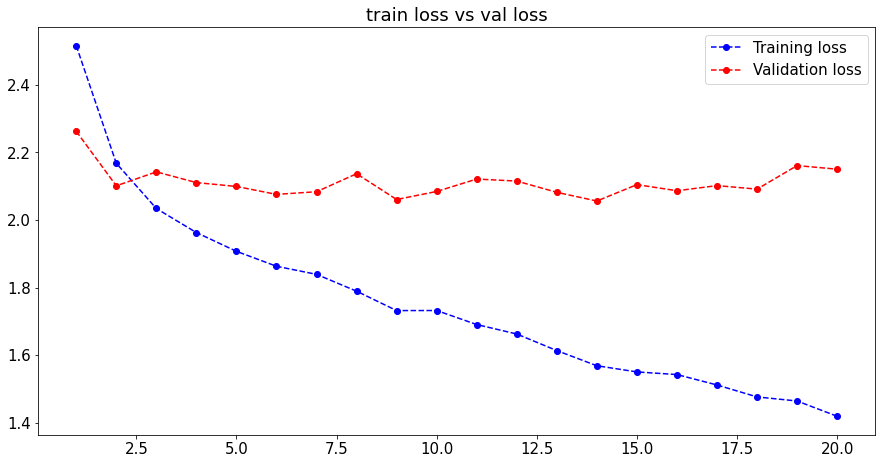

In [ ]:
tf.keras.backend.clear_session()

optimizer = tf.keras.optimizers.SGD(
  learning_rate= 0.001)

model_from_scratch.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer,
metrics=["accuracy"])

history = model_from_scratch.fit_generator(train_dataset,
                    epochs=20,
                    validation_data=val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

Data augmentation

In [ ]:
data_augmentation = keras.Sequential (
            [
            layers.RandomFlip("horizontal"), # effet mirroir 
            layers.RandomRotation(0.4), 
            layers.RandomZoom(0.2),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1)])

In [ ]:
# On ajoute l'augmentation des données à notre premier modèle
inputs = keras.Input(shape=SIZE_3D)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(n_races, activation="softmax")(x)

model_fs_aug = keras.Model(inputs=inputs, outputs=outputs)

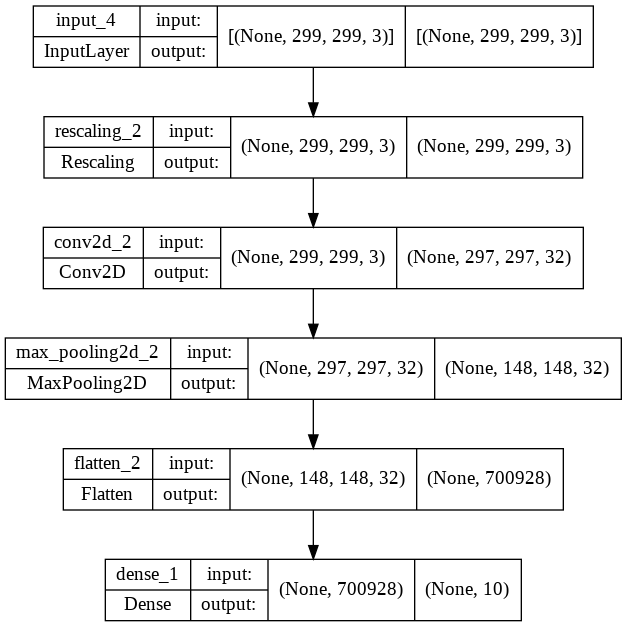

In [ ]:
tf.keras.utils.plot_model(model_fs_aug, show_shapes=True, to_file = '{}/model_FS_1.png'.format(root))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


48/48 [==============================] - 8s 145ms/step - loss: 22.0922 - accuracy: 0.1261 - val_loss: 2.5804 - val_accuracy: 0.1933
Epoch 2/20
48/48 [==============================] - 6s 112ms/step - loss: 1.8080 - accuracy: 0.4174 - val_loss: 2.2836 - val_accuracy: 0.2371
Epoch 3/20
48/48 [==============================] - 7s 130ms/step - loss: 0.7595 - accuracy: 0.8269 - val_loss: 2.3825 - val_accuracy: 0.2964
Epoch 4/20
48/48 [==============================] - 6s 114ms/step - loss: 0.2383 - accuracy: 0.9700 - val_loss: 2.6596 - val_accuracy: 0.2784
Epoch 5/20
48/48 [==============================] - 6s 115ms/step - loss: 0.1027 - accuracy: 0.9895 - val_loss: 2.9761 - val_accuracy: 0.2809
Epoch 6/20
48/48 [==============================] - 6s 116ms/step - loss: 0.0519 - accuracy: 0.9954 - val_loss: 2.7558 - val_accuracy: 0.2912
Epoch 7/20
48/48 [==============================] - 6s 116ms/step - loss: 0.0350 - accuracy: 0.9974 - val_loss: 2.8829 - val_accuracy: 0.3067
Epoch 8/20
48/48

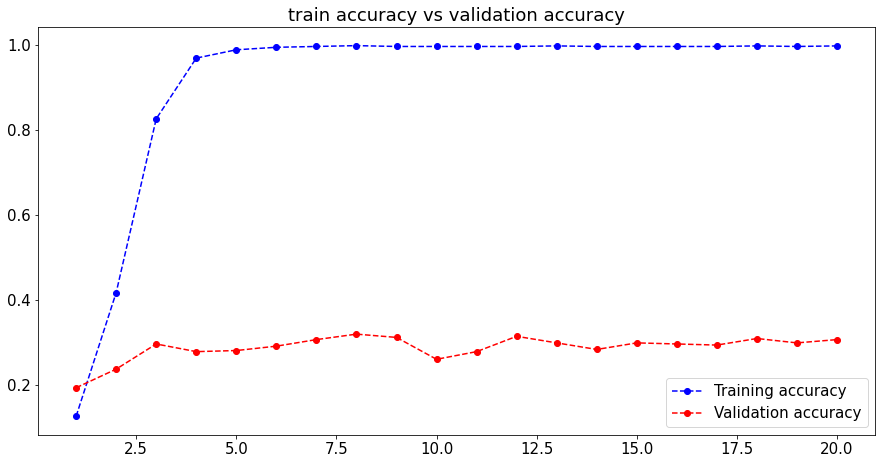

<Figure size 432x288 with 0 Axes>

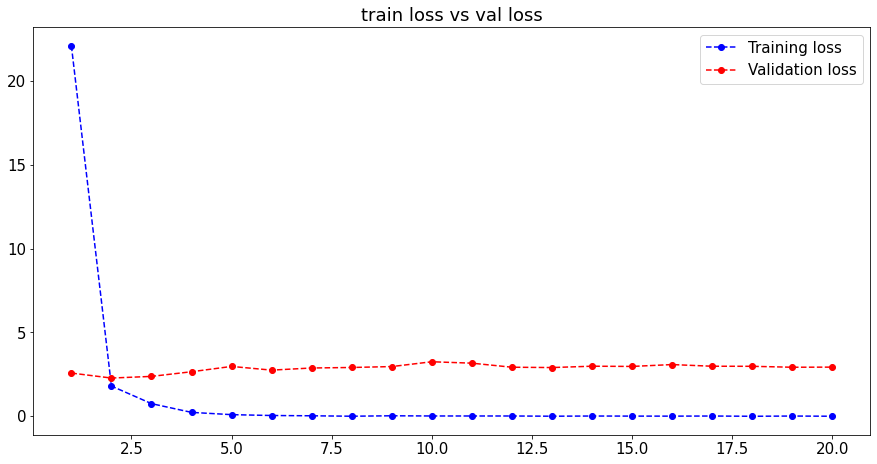

In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.001)

model_fs_aug.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer,
metrics=["accuracy"])

history = model_fs_aug.fit_generator(train_dataset,
                    epochs=20,
                    validation_data=val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


48/48 [==============================] - 6s 117ms/step - loss: 2.3005 - accuracy: 0.1372 - val_loss: 2.2531 - val_accuracy: 0.1418
Epoch 2/20
48/48 [==============================] - 6s 114ms/step - loss: 2.1350 - accuracy: 0.2188 - val_loss: 2.1666 - val_accuracy: 0.2242
Epoch 3/20
48/48 [==============================] - 6s 114ms/step - loss: 2.0658 - accuracy: 0.2567 - val_loss: 2.1076 - val_accuracy: 0.2010
Epoch 4/20
48/48 [==============================] - 6s 114ms/step - loss: 1.9973 - accuracy: 0.2965 - val_loss: 2.0886 - val_accuracy: 0.2423
Epoch 5/20
48/48 [==============================] - 6s 114ms/step - loss: 1.9512 - accuracy: 0.3207 - val_loss: 2.0501 - val_accuracy: 0.2552
Epoch 6/20
48/48 [==============================] - 6s 115ms/step - loss: 1.9050 - accuracy: 0.3475 - val_loss: 2.0838 - val_accuracy: 0.2500
Epoch 7/20
48/48 [==============================] - 6s 115ms/step - loss: 1.8671 - accuracy: 0.3592 - val_loss: 2.1184 - val_accuracy: 0.2680
Epoch 8/20
48/48 

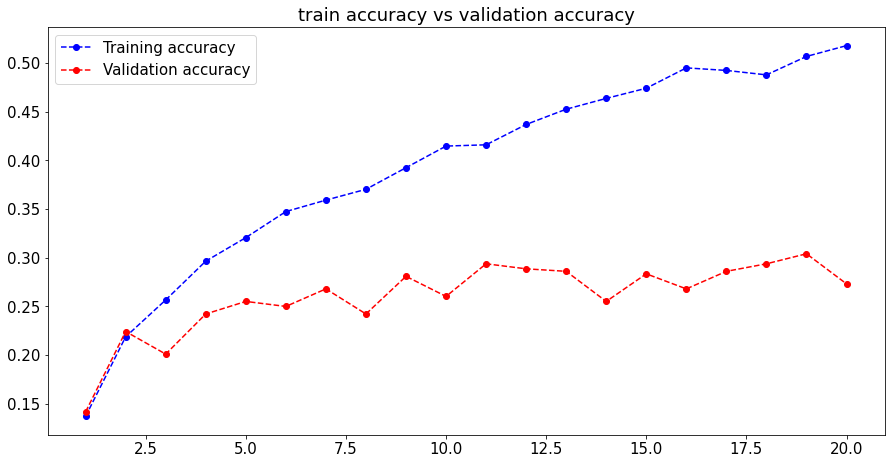

<Figure size 432x288 with 0 Axes>

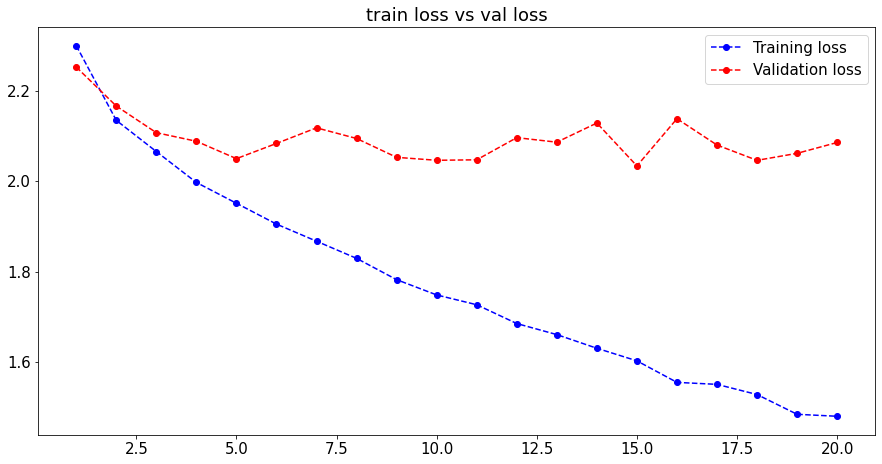

In [ ]:
optimizer = tf.keras.optimizers.SGD(
  learning_rate= 0.001)

model_fs_aug.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer,
metrics=["accuracy"])

history = model_fs_aug.fit_generator(train_dataset,
                    epochs=20,
                    validation_data=val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

In [ ]:
# Pour ce modèle on ajoute des layers de normalisations ainsi qu'un layer de dropout 
inputs = keras.Input(shape=SIZE_3D)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_races, activation="softmax")(x)

model2_from_scratch = keras.Model(inputs=inputs, outputs=outputs)

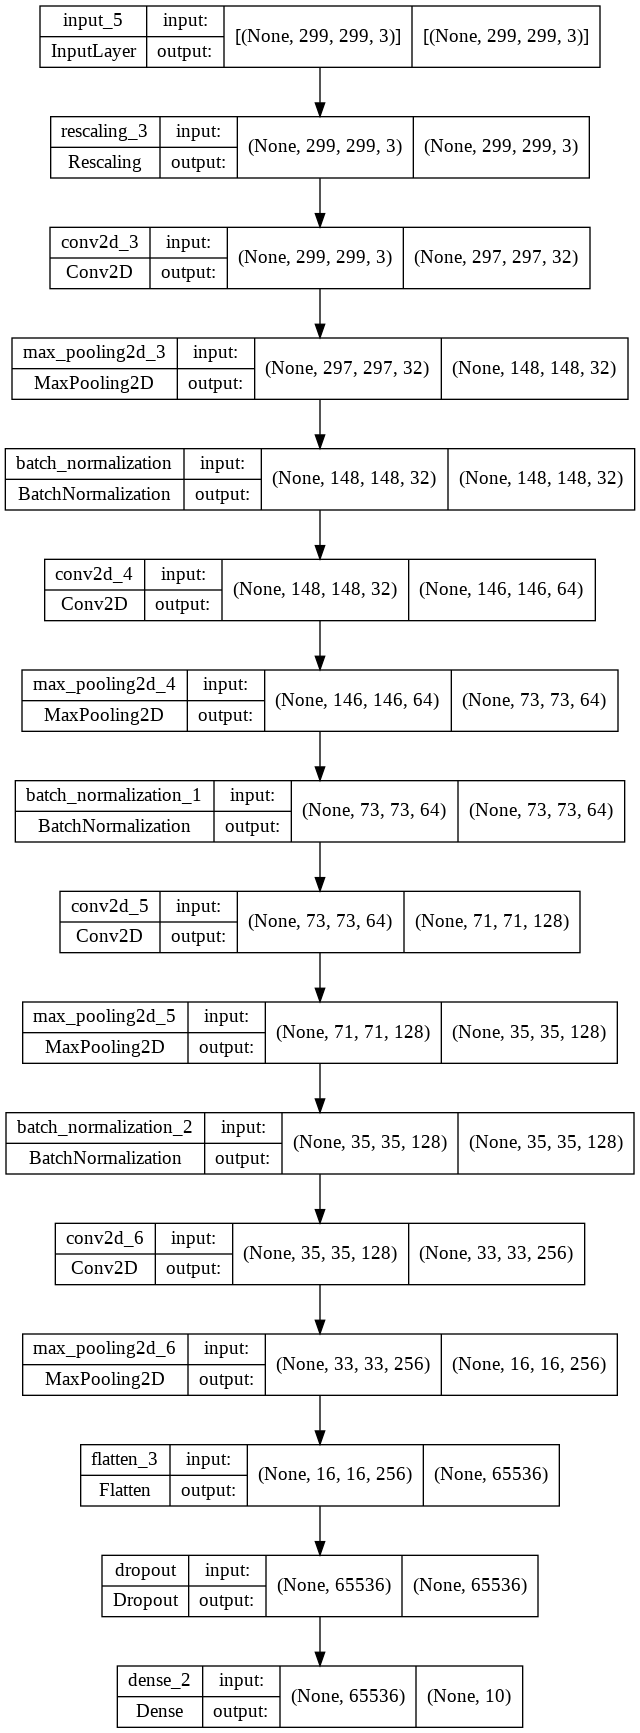

In [ ]:
tf.keras.utils.plot_model(model2_from_scratch, show_shapes=True, to_file = '{}/model_FS_2.png'.format(root))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


48/48 [==============================] - 8s 151ms/step - loss: 10.1345 - accuracy: 0.1470 - val_loss: 2.9279 - val_accuracy: 0.1418
Epoch 2/20
48/48 [==============================] - 8s 149ms/step - loss: 3.5541 - accuracy: 0.2247 - val_loss: 5.3846 - val_accuracy: 0.1314
Epoch 3/20
48/48 [==============================] - 8s 148ms/step - loss: 3.3608 - accuracy: 0.3227 - val_loss: 5.3267 - val_accuracy: 0.1469
Epoch 4/20
48/48 [==============================] - 8s 149ms/step - loss: 3.1569 - accuracy: 0.3873 - val_loss: 5.3927 - val_accuracy: 0.1495
Epoch 5/20
48/48 [==============================] - 8s 148ms/step - loss: 2.2270 - accuracy: 0.4664 - val_loss: 6.6476 - val_accuracy: 0.1289
Epoch 6/20
48/48 [==============================] - 8s 148ms/step - loss: 1.4328 - accuracy: 0.5898 - val_loss: 3.1343 - val_accuracy: 0.1753
Epoch 7/20
48/48 [==============================] - 8s 148ms/step - loss: 0.9185 - accuracy: 0.6982 - val_loss: 2.5681 - val_accuracy: 0.2577
Epoch 8/20
48/48

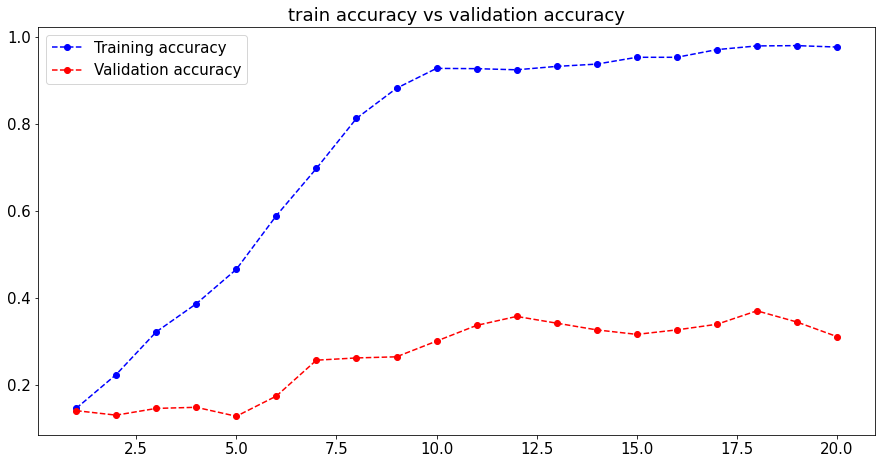

<Figure size 432x288 with 0 Axes>

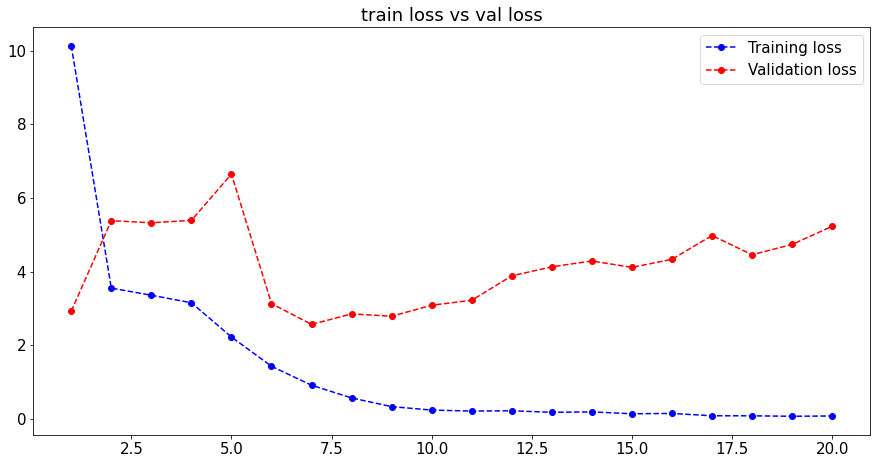

In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.001)

model2_from_scratch.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer,
metrics=["accuracy"])

history = model2_from_scratch.fit_generator(train_dataset,
                    epochs=20,
                    validation_data=val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


48/48 [==============================] - 8s 152ms/step - loss: 2.8331 - accuracy: 0.2116 - val_loss: 2.2871 - val_accuracy: 0.1314
Epoch 2/20
48/48 [==============================] - 8s 148ms/step - loss: 1.8310 - accuracy: 0.4030 - val_loss: 2.3143 - val_accuracy: 0.1314
Epoch 3/20
48/48 [==============================] - 8s 149ms/step - loss: 1.3614 - accuracy: 0.5317 - val_loss: 2.5936 - val_accuracy: 0.1418
Epoch 4/20
48/48 [==============================] - 8s 149ms/step - loss: 1.0415 - accuracy: 0.6349 - val_loss: 2.6706 - val_accuracy: 0.1418
Epoch 5/20
48/48 [==============================] - 8s 148ms/step - loss: 0.9098 - accuracy: 0.6878 - val_loss: 2.7217 - val_accuracy: 0.1392
Epoch 6/20
48/48 [==============================] - 8s 149ms/step - loss: 0.6507 - accuracy: 0.7864 - val_loss: 2.6068 - val_accuracy: 0.1443
Epoch 7/20
48/48 [==============================] - 8s 149ms/step - loss: 0.5221 - accuracy: 0.8263 - val_loss: 2.6331 - val_accuracy: 0.1624
Epoch 8/20
48/48 

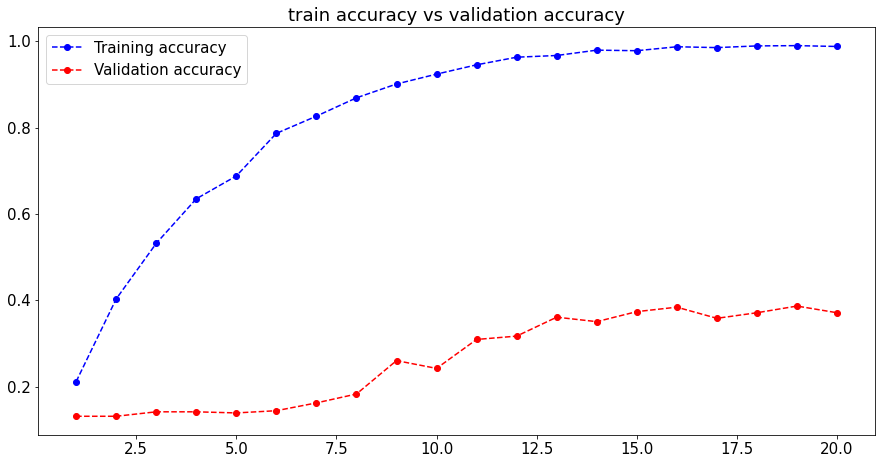

<Figure size 432x288 with 0 Axes>

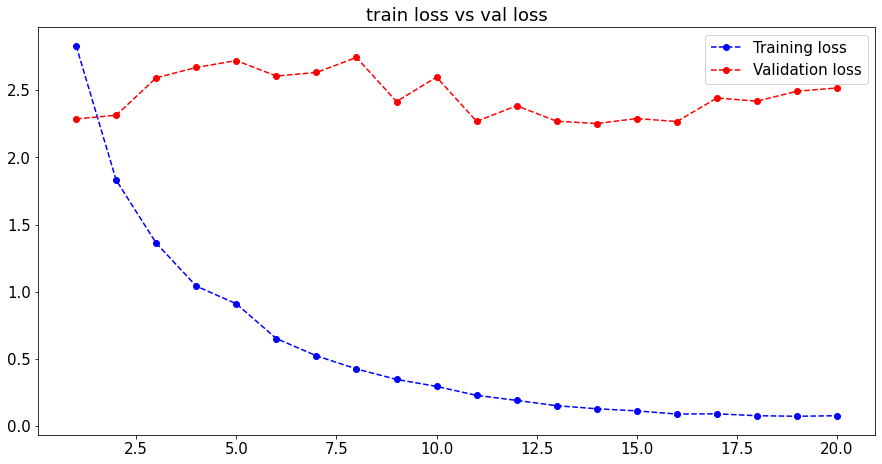

In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.0001)

model2_from_scratch.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer,
metrics=["accuracy"])

history = model2_from_scratch.fit_generator(train_dataset,
                    epochs=20,
                    validation_data=val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

Transfer learning

In [ ]:
model_base = InceptionV3(weights = "imagenet", include_top = False)
model_base.trainable = False

# On ajoute à notre réseau des layers de classification
inputs = keras.Input(shape = SIZE_3D)
x = data_augmentation(inputs) # uniquement en train
x = preprocess_input(x)
x = model_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_races, activation="softmax")(x)

model_transfer = keras.Model(inputs=inputs, outputs=outputs)

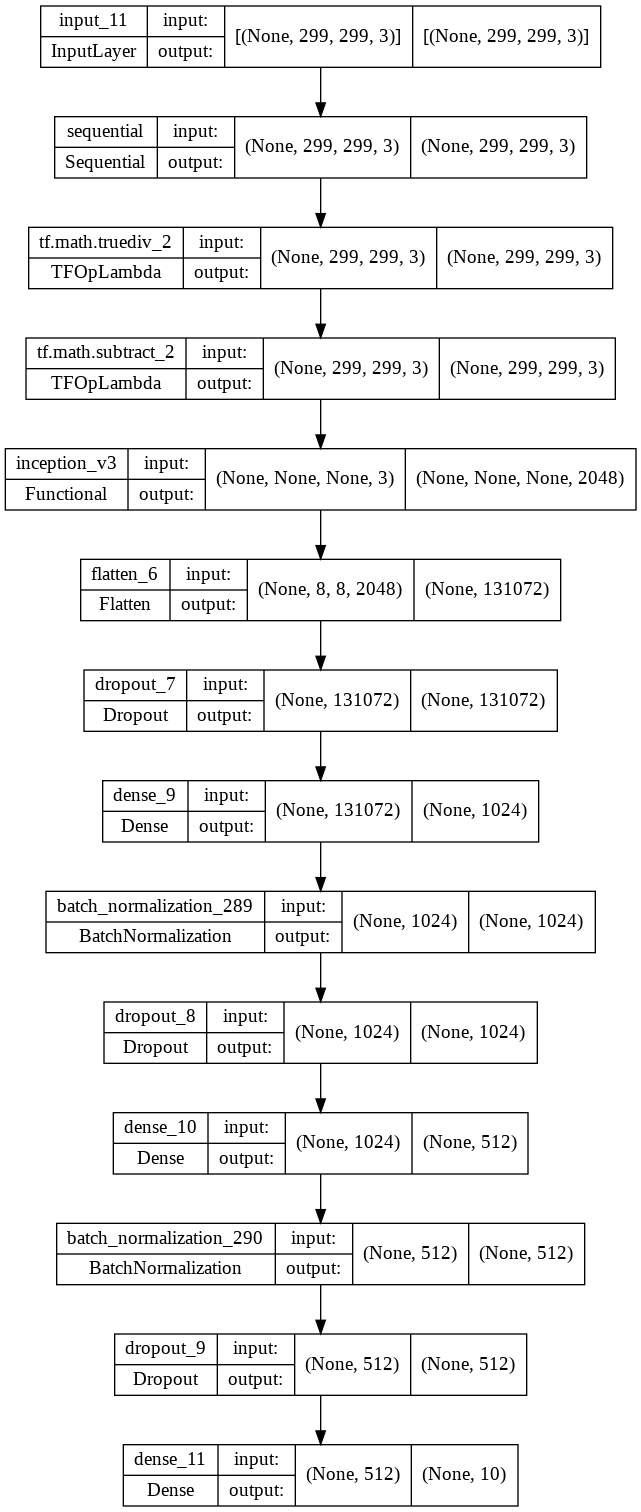

In [ ]:
tf.keras.utils.plot_model(model_transfer, show_shapes=True, to_file = '{}/model_transfer.png'.format(root))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


48/48 [==============================] - 21s 283ms/step - loss: 1.6238 - accuracy: 0.5330 - val_loss: 0.2557 - val_accuracy: 0.9253
Epoch 2/20
48/48 [==============================] - 10s 202ms/step - loss: 0.9341 - accuracy: 0.7126 - val_loss: 0.1244 - val_accuracy: 0.9639
Epoch 3/20
48/48 [==============================] - 10s 203ms/step - loss: 0.8075 - accuracy: 0.7642 - val_loss: 0.1115 - val_accuracy: 0.9691
Epoch 4/20
48/48 [==============================] - 10s 205ms/step - loss: 0.7624 - accuracy: 0.7590 - val_loss: 0.1131 - val_accuracy: 0.9562
Epoch 5/20
48/48 [==============================] - 12s 223ms/step - loss: 0.7287 - accuracy: 0.7747 - val_loss: 0.1265 - val_accuracy: 0.9639
Epoch 6/20
48/48 [==============================] - 10s 204ms/step - loss: 0.6911 - accuracy: 0.7910 - val_loss: 0.1105 - val_accuracy: 0.9742
Epoch 7/20
48/48 [==============================] - 11s 222ms/step - loss: 0.7006 - accuracy: 0.7929 - val_loss: 0.1080 - val_accuracy: 0.9665
Epoch 8/20

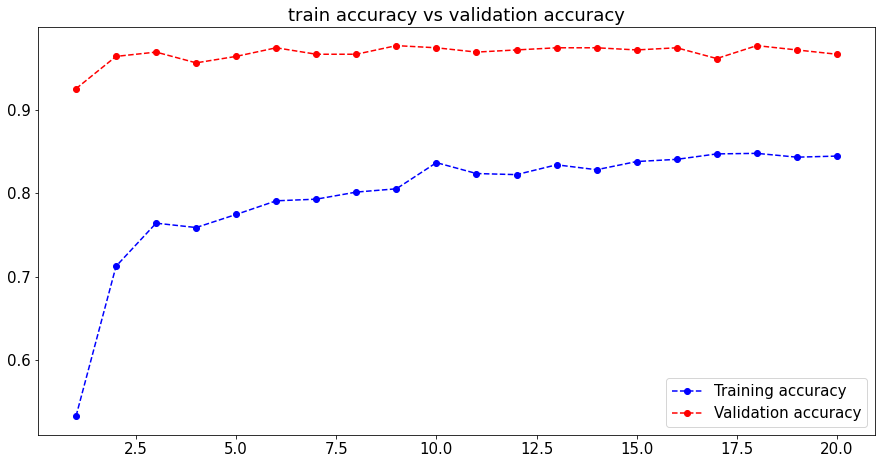

<Figure size 432x288 with 0 Axes>

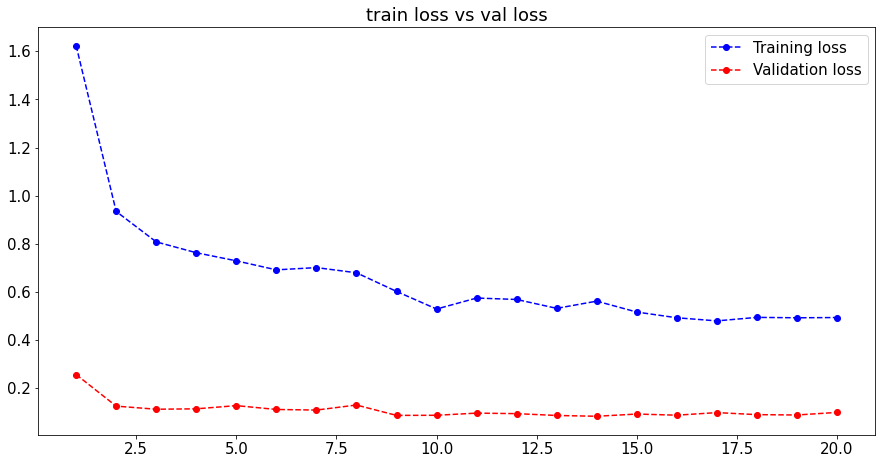

In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.0001)

model_transfer.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer, metrics=["accuracy"])

history = model_transfer.fit_generator(train_dataset, 
                                       epochs = 20,
                                       validation_data = val_dataset)

plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

Résultats finaux avec toutes les images

In [ ]:
model_base = InceptionV3(weights = "imagenet", include_top = False)
model_base.trainable = False

# On ajoute à notre réseau des layers de classification
inputs = keras.Input(shape = SIZE_3D)
x = data_augmentation(inputs) # uniquement en train
x = preprocess_input(x)
x = model_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_races_full, activation="softmax")(x)

model_transfer = keras.Model(inputs=inputs, outputs=outputs)

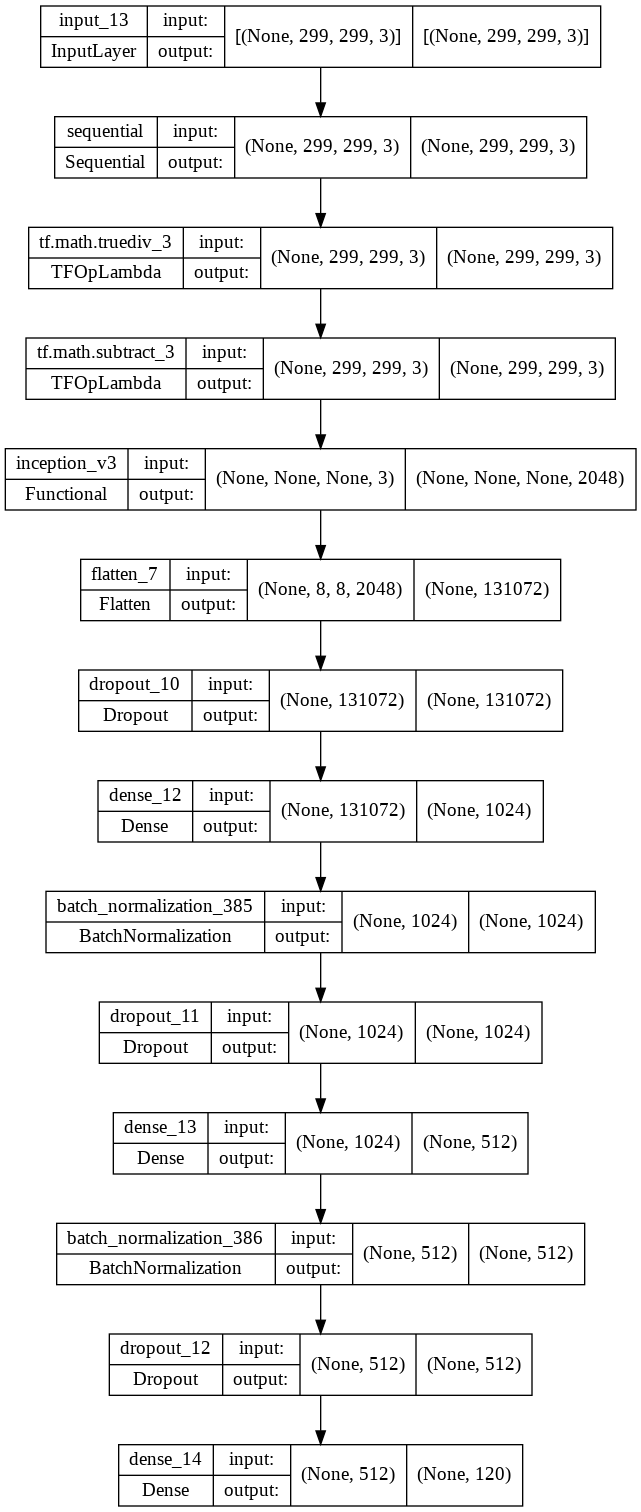

In [ ]:
tf.keras.utils.plot_model(model_transfer, show_shapes=True, to_file = '{}/model_transfer_final.png'.format(root))

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
                                filepath="{}/transfert_IV3".format(root),
                                save_best_only=True,
                                monitor="val_loss")]

optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.0001)

model_transfer.compile(loss="sparse_categorical_crossentropy",
optimizer= optimizer, metrics=["accuracy"])

history = model_transfer.fit_generator(train_dataset_full,
                          epochs = 40,
                          validation_data = val_dataset_full,
                          callbacks = callbacks)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


514/514 [==============================] - 2938s 6s/step - loss: 2.8526 - accuracy: 0.3256 - val_loss: 0.5787 - val_accuracy: 0.8085
Epoch 2/40
514/514 [==============================] - 103s 199ms/step - loss: 2.1413 - accuracy: 0.4436 - val_loss: 0.5063 - val_accuracy: 0.8443
Epoch 3/40
514/514 [==============================] - 103s 200ms/step - loss: 1.9442 - accuracy: 0.4856 - val_loss: 0.4565 - val_accuracy: 0.8527
Epoch 4/40
514/514 [==============================] - 103s 199ms/step - loss: 1.8186 - accuracy: 0.5107 - val_loss: 0.4539 - val_accuracy: 0.8558
Epoch 5/40
514/514 [==============================] - 103s 199ms/step - loss: 1.7477 - accuracy: 0.5250 - val_loss: 0.4424 - val_accuracy: 0.8614
Epoch 6/40
514/514 [==============================] - 103s 199ms/step - loss: 1.6912 - accuracy: 0.5361 - val_loss: 0.4378 - val_accuracy: 0.8633
Epoch 7/40
514/514 [==============================] - 103s 198ms/step - loss: 1.6711 - accuracy: 0.5401 - val_loss: 0.4423 - val_accuracy

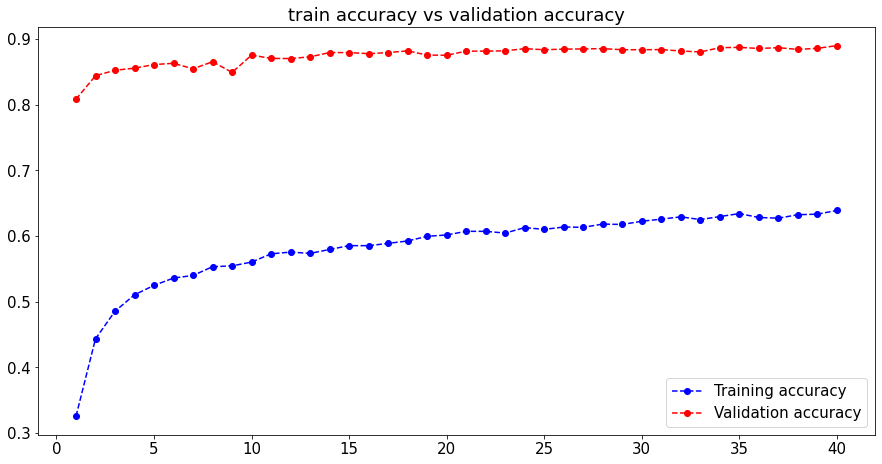

<Figure size 432x288 with 0 Axes>

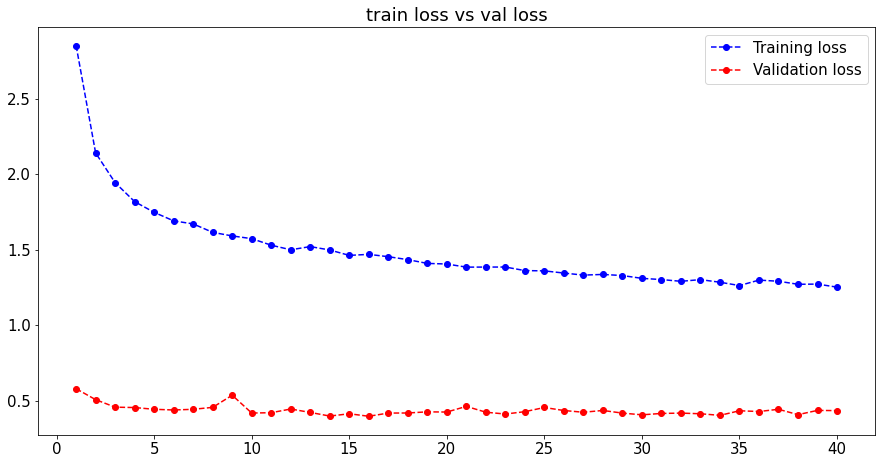

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', size=15) 
fig = plt.figure(figsize=(15,7.5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "ro--", label="Validation accuracy")
plt.title("train accuracy vs validation accuracy")
plt.legend()
plt.figure()
fig = plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, "bo--", label="Training loss")
plt.plot(epochs, val_loss, "ro--", label="Validation loss")
plt.title("train loss vs val loss")
plt.legend()
plt.show()

In [ ]:
# y_pred = model_transfer.predict(val_dataset)
# y_pred = np.argmax(y_pred, axis = 1)

# pickle.dump(y_pred, open(f"{root}/y_pred.pkl", "wb"))
y_pred = pickle.load(open(f"{root}/y_pred.pkl", "rb"))

In [ ]:
dico_classes = dict(enumerate(map(get_race_from_dir, val_dataset_full.class_names)))

In [ ]:
y_true_noms = list(map(dico_classes.get, y_true))
y_pred_noms = list(map(dico_classes.get, y_pred))

Evaluation du modèle

In [ ]:
from sklearn.metrics import classification_report


report = classification_report(y_true, 
                               y_pred,
                               target_names = list(map(get_race_from_dir, val_dataset_full.class_names)),
                               output_dict = True)

df_metrics = pd.DataFrame(report).round(2).T
df_metrics.sort_values(by = "f1-score", inplace = True)

for col in df_metrics.columns[:-1]:
  df_metrics[col] *= 100

Métriques globales

In [ ]:
df_metrics[df_metrics.index.str.islower()].iloc[1:]

,precision,recall,f1-score,support
macro avg,89.0,89.0,89.0,4162.0
weighted avg,89.0,89.0,89.0,4162.0


Métriques globales

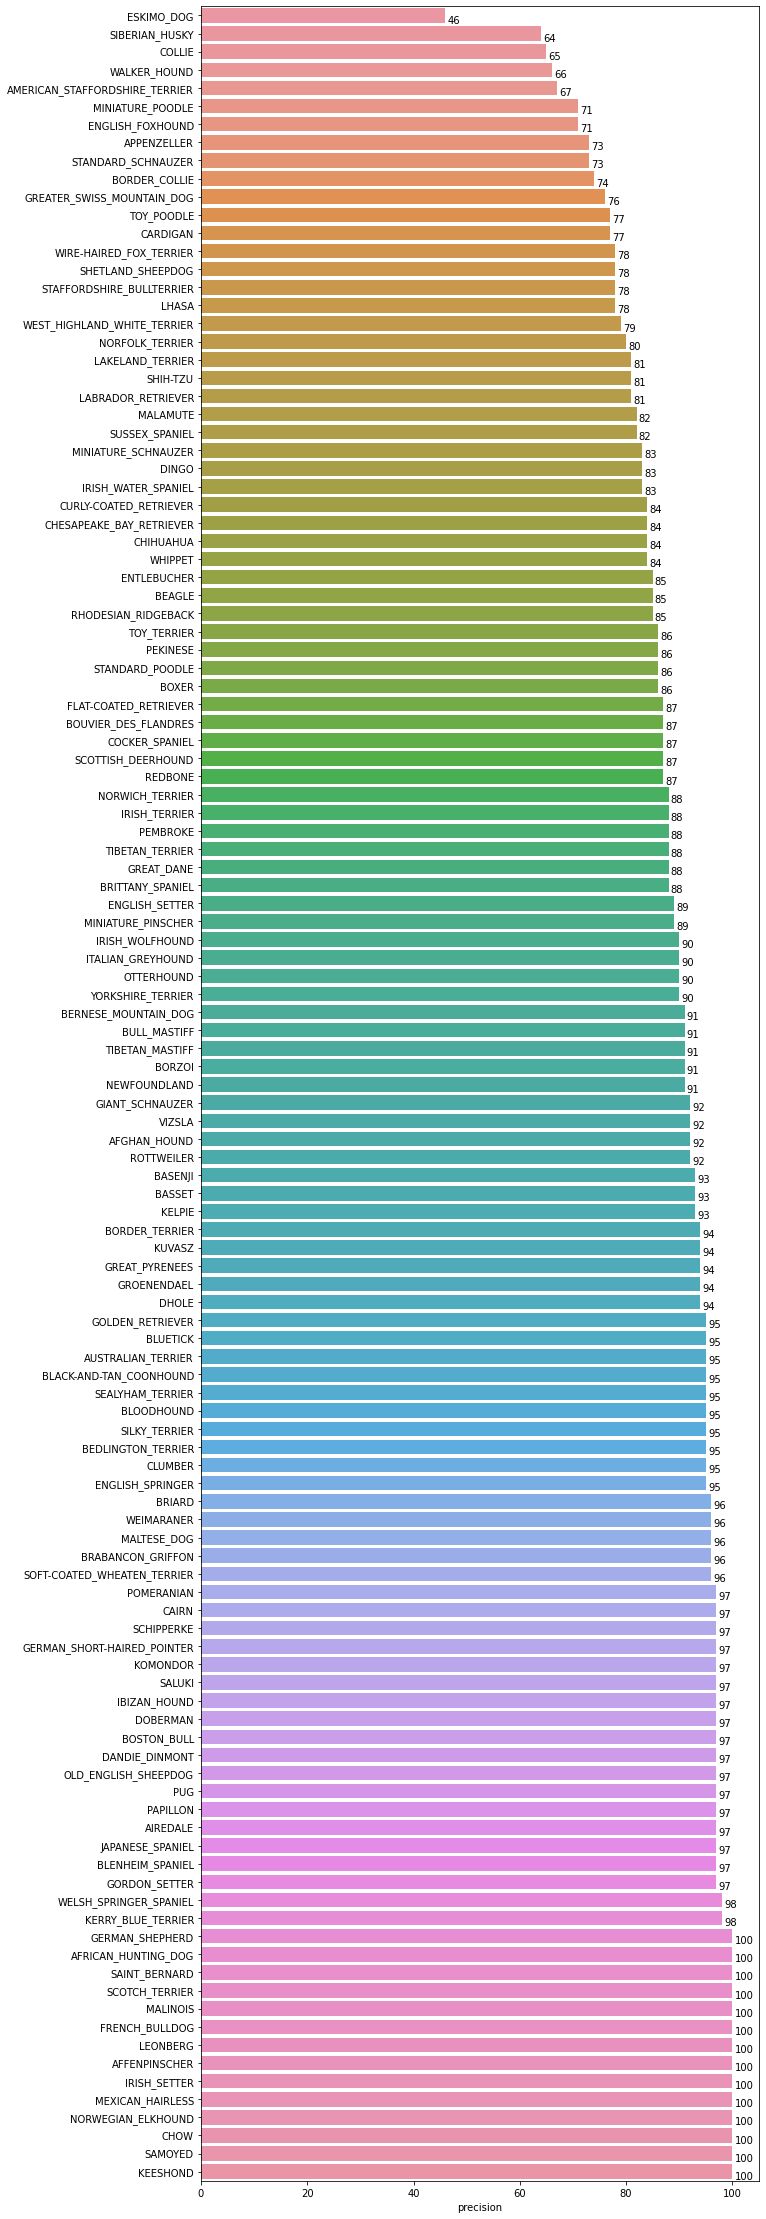

In [ ]:
plt.figure(figsize = (10, 40))

df = df_metrics[df_metrics.index.str.isupper()].copy()

ax = sns.barplot(data = df.sort_values(by = "precision"),
                 y = df.index,
                 x = "precision")
show_values_on_bars(ax, h_v="h", space=0.4)

plt.savefig('{}/precision_scores.png'.format(root))
plt.show()

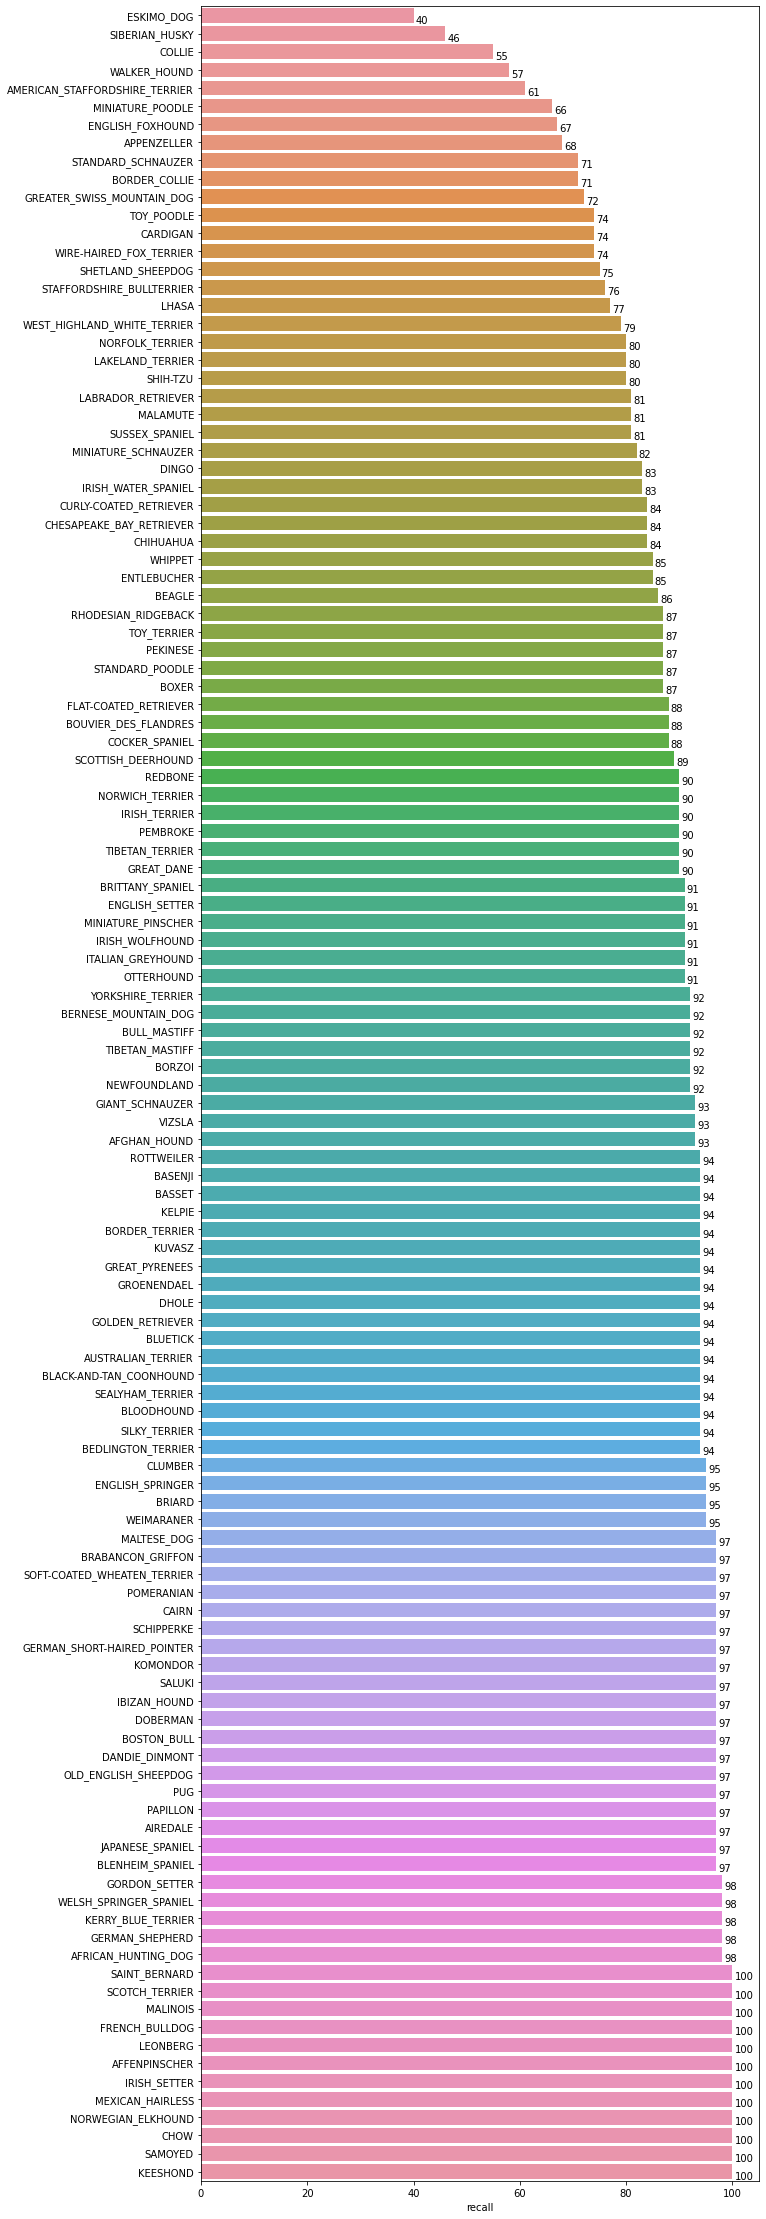

In [ ]:
plt.figure(figsize = (10, 40))

df = df_metrics[df_metrics.index.str.isupper()].copy()

ax = sns.barplot(data = df.sort_values(by = "recall"),
                 y = df.index,
                 x = "recall")
show_values_on_bars(ax, h_v="h", space=0.4)

plt.savefig('{}/recall_scores.png'.format(root))
plt.show()

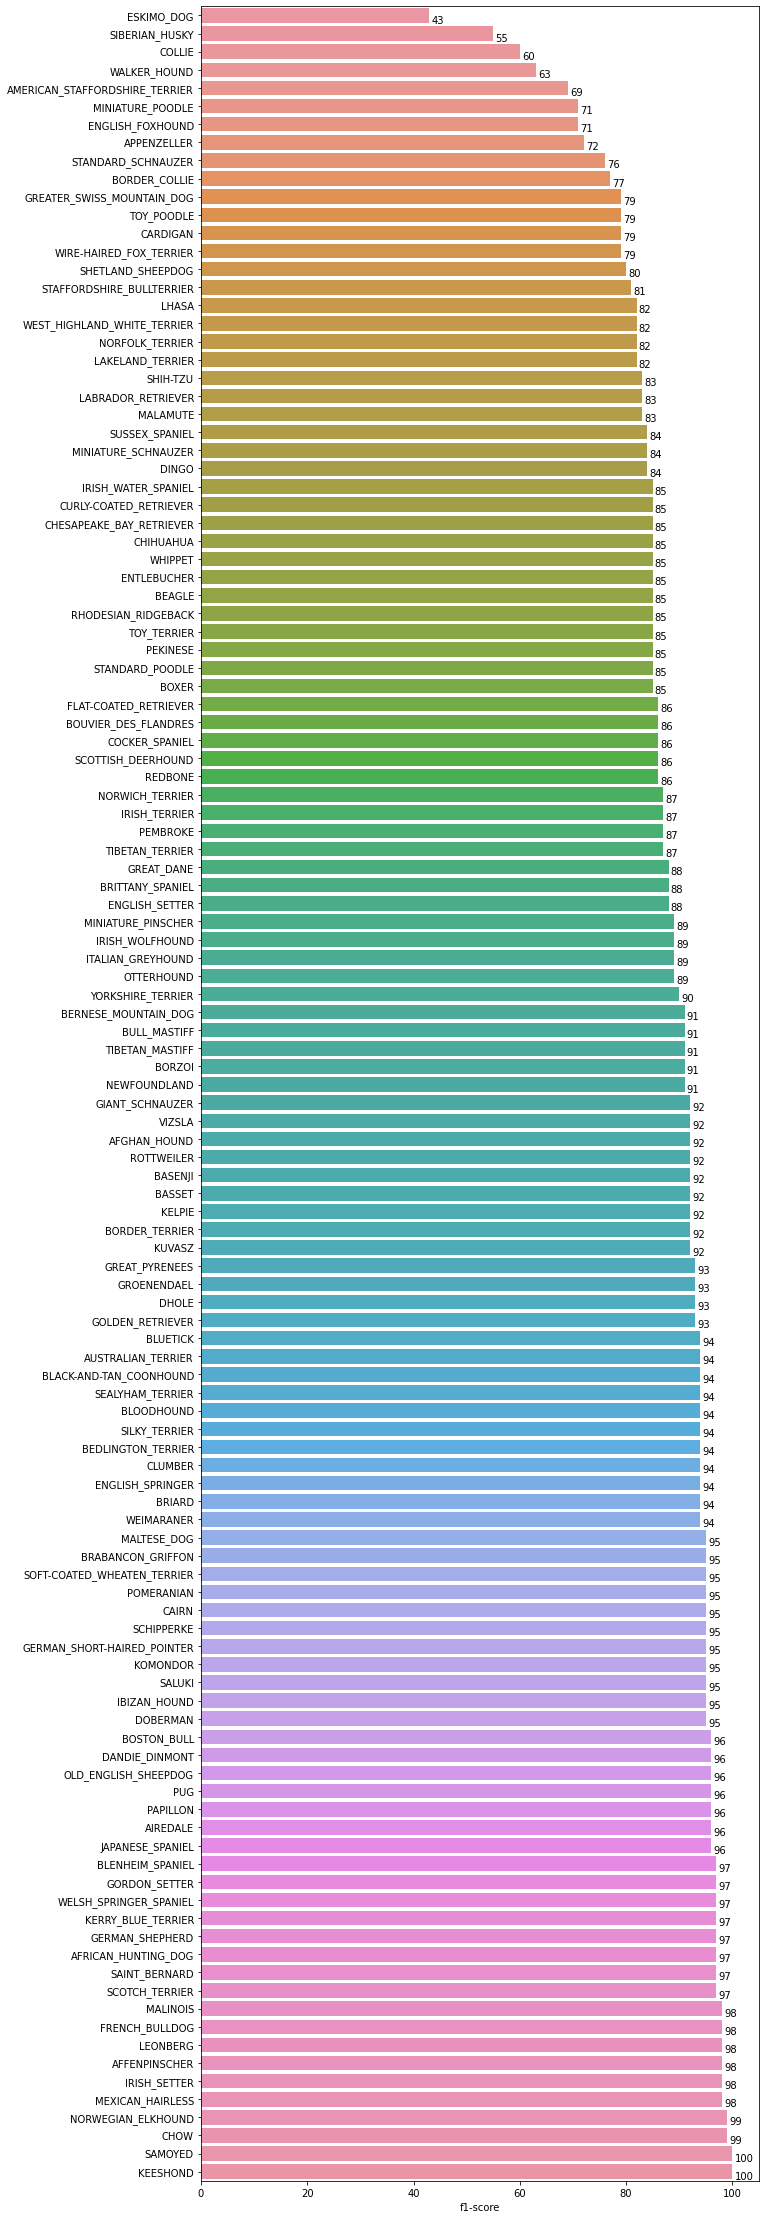

In [ ]:
plt.figure(figsize = (10, 40))

df = df_metrics[df_metrics.index.str.isupper()].copy()

ax = sns.barplot(data = df.sort_values(by = "f1-score"),
                 y = df.index,
                 x = "f1-score")
show_values_on_bars(ax, h_v="h", space=0.4)

plt.savefig('{}/f1_scores.png'.format(root))
plt.show()

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
np.fill_diagonal(cf_matrix, 0) # la diagonale est mise à 0 pour se focaliser sur les erreurs commises

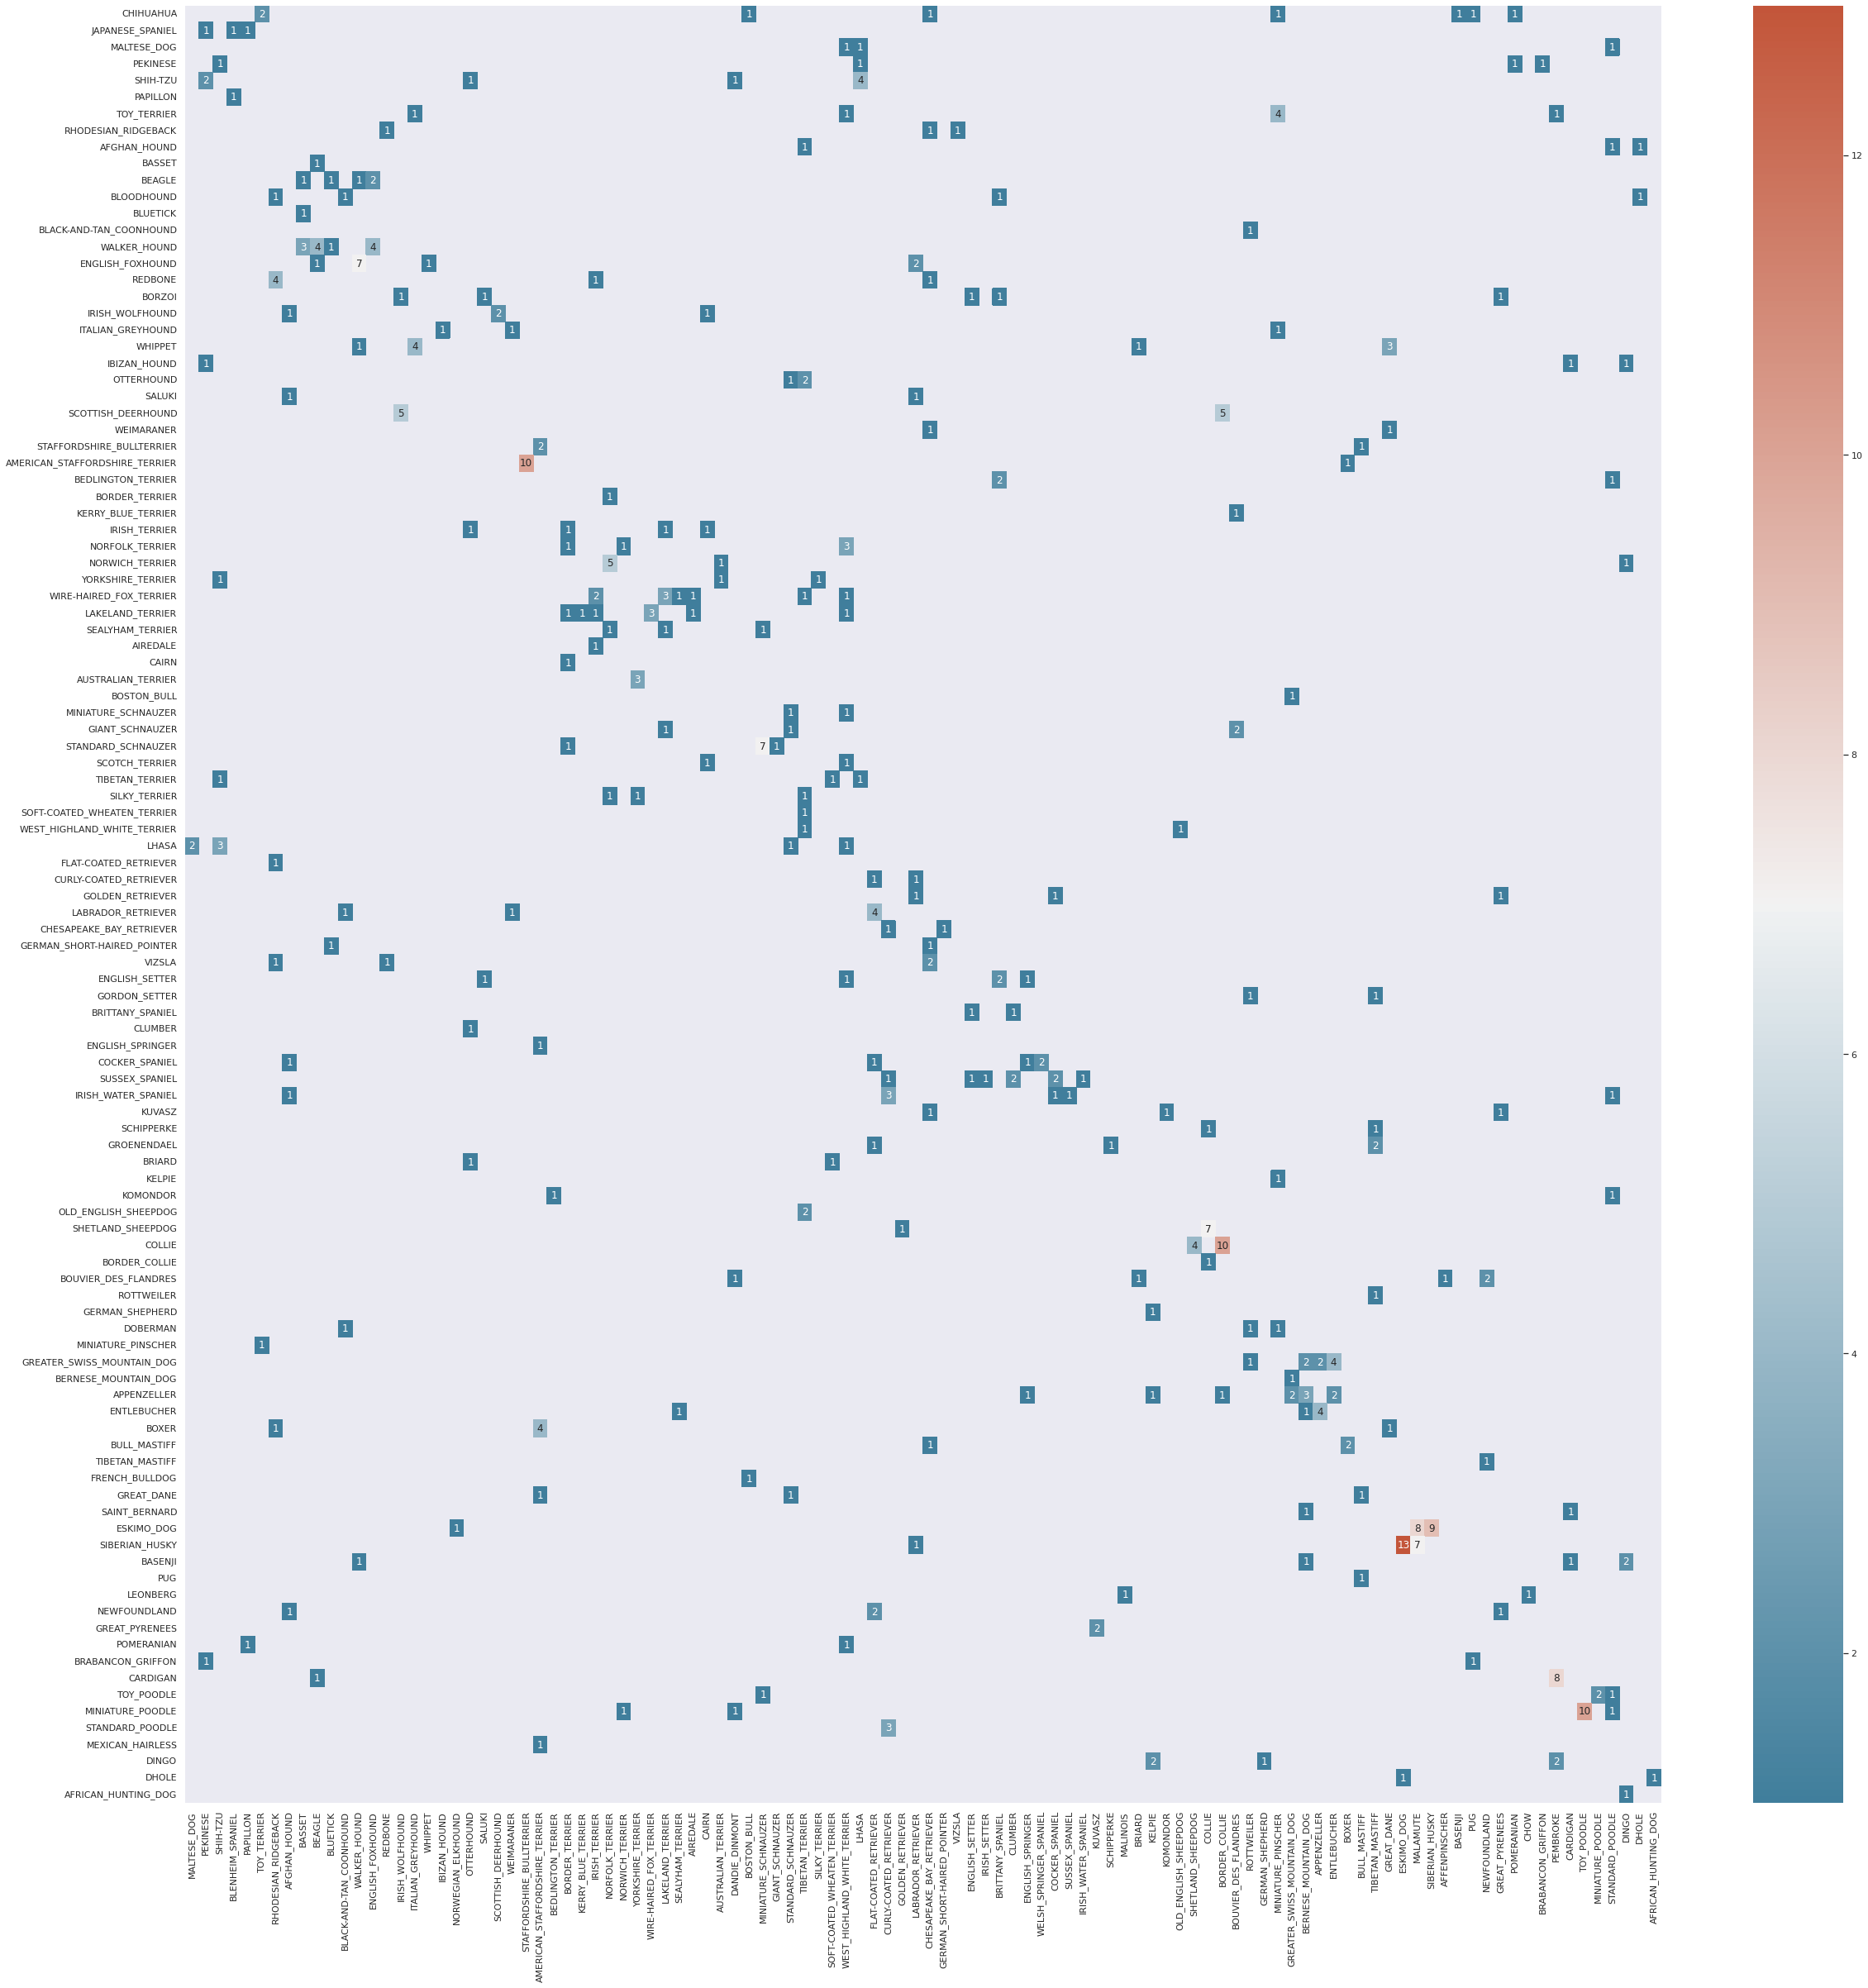

In [ ]:
df_corr_full = \
pd.DataFrame(cf_matrix, 
             columns = list(dico_classes.values()), 
             index = list(dico_classes.values()))

# suppression des lignes et colonnes entièrement nulles de la matrice de corrélation
df_corr = df_corr_full[df_corr_full != 0].dropna(how = "all").dropna(how = "all", axis = 1).copy()

mask = df_corr == 0 
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize = (40, 40))
sns.set(font_scale = 1)
sns.heatmap(df_corr, mask = mask, cmap = cmap, annot = True)
plt.savefig('{}/confusion_matrix.png'.format(root))
plt.show()

# abscisse : y_pred, ordonnée : y_true

In [ ]:
# localisation des couples avec plus de 5 erreurs 
df_err = df_corr[df_corr >= 5].dropna(how = "all").dropna(axis = 1, how = "all").fillna("")

df_err

,WALKER_HOUND,IRISH_WOLFHOUND,STAFFORDSHIRE_BULLTERRIER,NORFOLK_TERRIER,MINIATURE_SCHNAUZER,COLLIE,BORDER_COLLIE,ESKIMO_DOG,MALAMUTE,SIBERIAN_HUSKY,PEMBROKE,TOY_POODLE
ENGLISH_FOXHOUND,7.0,,,,,,,,,,,
SCOTTISH_DEERHOUND,,5.0,,,,,5.0,,,,,
AMERICAN_STAFFORDSHIRE_TERRIER,,,10.0,,,,,,,,,
NORWICH_TERRIER,,,,5.0,,,,,,,,
STANDARD_SCHNAUZER,,,,,7.0,,,,,,,
SHETLAND_SHEEPDOG,,,,,,7.0,,,,,,
COLLIE,,,,,,,10.0,,,,,
ESKIMO_DOG,,,,,,,,,8.0,9.0,,
SIBERIAN_HUSKY,,,,,,,,13.0,7.0,,,
CARDIGAN,,,,,,,,,,,8.0,


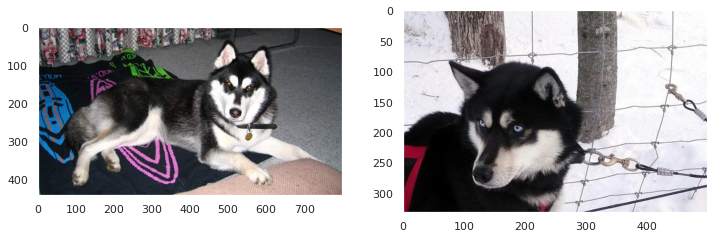

In [ ]:
check_plot(val_dataset_full.file_paths, "SIBERIAN_HUSKY", "ESKIMO_DOG")